In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scrapper import *
from datetime import datetime
import calendar
from dateutil.relativedelta import relativedelta

%matplotlib inline

### Import Data

In [2]:
sue_df = pd.read_csv("actual_sp500_stock_es.csv")
name_df = pd.read_csv("company_name.csv")

In [3]:
sue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439956 entries, 0 to 439955
Data columns (total 12 columns):
OFTIC        439956 non-null object
anndats      439956 non-null object
TICKER       439956 non-null object
MEASURE      439956 non-null object
FISCALP      439956 non-null object
PYEAR        439956 non-null int64
PMON         439956 non-null int64
USFIRM       439956 non-null int64
actual       413757 non-null float64
surpmean     439956 non-null float64
surpstdev    334039 non-null float64
suescore     312485 non-null float64
dtypes: float64(4), int64(3), object(5)
memory usage: 40.3+ MB


In [4]:
sue_df = sue_df[(sue_df['MEASURE']=='EPS') & (sue_df['USFIRM']==1)]
combine_df = pd.merge(sue_df, name_df, left_on='TICKER', right_on='tic', how='inner')
combine_df.head()

,OFTIC,anndats,TICKER,MEASURE,FISCALP,PYEAR,PMON,USFIRM,actual,surpmean,...,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,costat
0,AA,2000-01-10,AA,EPS,QTR,1999,12,1,1.335,1.15385,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A
1,AA,2000-04-06,AA,EPS,QTR,2000,3,1,1.425,1.35625,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A
2,AA,2000-07-10,AA,EPS,QTR,2000,6,1,1.410,1.41125,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A
3,AA,2000-10-05,AA,EPS,QTR,2000,9,1,1.260,1.34875,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A
4,AA,2001-01-08,AA,EPS,QTR,2000,12,1,1.350,1.28250,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A


### Data Cleaning & Feature Engineering

In [5]:
eps_df = combine_df.loc[:, ['TICKER', 'conm', 'PYEAR', 'PMON', 'suescore']]
eps_df.describe()

,PYEAR,PMON,suescore
count,22737.000000,22737.000000,22472.000000
mean,2009.194617,7.177332,1.434950
std,5.464804,3.415661,4.769791
min,1999.000000,1.000000,-137.628600
25%,2005.000000,3.000000,-0.029235
50%,2009.000000,6.000000,1.028980
75%,2014.000000,9.000000,2.541393
max,2018.000000,12.000000,147.786730


In [6]:
# remove outliers
quantile = eps_df['suescore'].quantile([0.01, 0.99])
center_df = eps_df[(eps_df['suescore']>=quantile.iloc[0]) & (eps_df['suescore']<=quantile.iloc[1])]
center_df.head()

,TICKER,conm,PYEAR,PMON,suescore
0,AA,ALCOA CORP,1999,12,5.64507
1,AA,ALCOA CORP,2000,3,0.53647
2,AA,ALCOA CORP,2000,6,-0.00815
3,AA,ALCOA CORP,2000,9,-0.58508
4,AA,ALCOA CORP,2000,12,0.83302


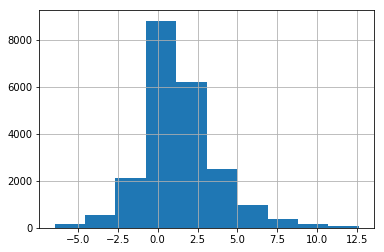

In [7]:
center_df['suescore'].hist()

In [8]:
SCORE_THRESH = 10
pos_surp = eps_df[eps_df['suescore']>=SCORE_THRESH].drop_duplicates()
pos_surp.head()

,TICKER,conm,PYEAR,PMON,suescore
98,AAPL,APPLE INC,2006,12,11.30582
110,AAPL,APPLE INC,2009,12,11.93050
153,ABBV,ABBVIE INC,2014,9,12.92551
313,ADBE,ADOBE INC,2017,2,10.89850
358,ADI,ANALOG DEVICES,2009,4,18.13989


In [9]:
pos_surp['conm'].unique()[:10]

array(['APPLE INC', 'ABBVIE INC', 'ADOBE INC', 'ANALOG DEVICES',
       'ARCHER-DANIELS-MIDLAND CO', 'ACADIA PHARMACEUTICALS INC',
       'AMERICAN ELECTRIC POWER CO', 'ALLERGAN PLC',
       'AMERICAN INTERNATIONAL GROUP', 'APARTMENT INVST & MGMT CO'],
      dtype=object)

### Time Series Analysis

In [10]:
ticker_size = eps_df.groupby(['TICKER']).size()
max_ticker = ticker_size[ticker_size==ticker_size.max()].index[0]
ts_df = eps_df[eps_df['TICKER']==max_ticker]
ts_df['date'] = ts_df.apply(lambda x: pd.to_datetime('{}/{}/01'.format(x['PYEAR'], x['PMON'])), axis=1)
ts_df = ts_df.set_index(['date'])
ts_df = ts_df.resample('Q').last()
ts_df.head()

/Users/niniliu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,TICKER,conm,PYEAR,PMON,suescore
date,,,,,
1999-12-31,CB,CHUBB LTD,1999,12,0.23743
2000-03-31,CB,CHUBB LTD,2000,3,-1.72672
2000-06-30,CB,CHUBB LTD,2000,6,0.56470
2000-09-30,CB,CHUBB LTD,2000,9,-1.55563
2000-12-31,CB,CHUBB LTD,2000,12,-3.00000


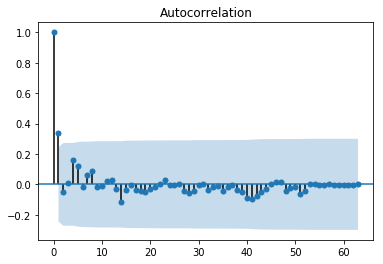

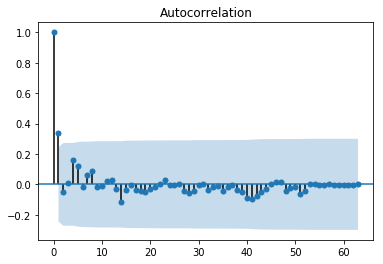

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_df['suescore'])

In [12]:
from arch import arch_model
am = arch_model(ts_df['suescore'])
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 211.20809228543345
Iteration:      2,   Func. Count:     14,   Neg. LLF: 210.69712025397996
Iteration:      3,   Func. Count:     20,   Neg. LLF: 190.73834013250087
Iteration:      4,   Func. Count:     31,   Neg. LLF: 188.39528687146316
Iteration:      5,   Func. Count:     38,   Neg. LLF: 187.68367641587696
Iteration:      6,   Func. Count:     45,   Neg. LLF: 186.9531101620148
Iteration:      7,   Func. Count:     51,   Neg. LLF: 186.74606716691886
Iteration:      8,   Func. Count:     57,   Neg. LLF: 186.52941582930853
Iteration:      9,   Func. Count:     63,   Neg. LLF: 186.52271195010644
Iteration:     10,   Func. Count:     69,   Neg. LLF: 186.52267678974022
Iteration:     11,   Func. Count:     75,   Neg. LLF: 186.5226497283683
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 186.52264972832447
            Iterations: 15
            Function evaluations: 75
            Grad

/Users/niniliu/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [13]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               suescore   R-squared:                      -0.031
Mean Model:             Constant Mean   Adj. R-squared:                 -0.031
Vol Model:                      GARCH   Log-Likelihood:               -186.523
Distribution:                  Normal   AIC:                           381.045
Method:            Maximum Likelihood   BIC:                           389.681
                                        No. Observations:                   64
Date:                Wed, Apr 10 2019   Df Residuals:                       60
Time:                        09:52:29   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.6244      0.462      3.519  4.330e-04 [  0.720,  2.52

### NLP Processing

In [14]:
pos_surp.head()

,TICKER,conm,PYEAR,PMON,suescore
98,AAPL,APPLE INC,2006,12,11.30582
110,AAPL,APPLE INC,2009,12,11.93050
153,ABBV,ABBVIE INC,2014,9,12.92551
313,ADBE,ADOBE INC,2017,2,10.89850
358,ADI,ANALOG DEVICES,2009,4,18.13989


In [15]:
def get_start_end_date(year, month, frequency='Q'):
    month_end = calendar.monthrange(year, month)[1]
    end_date = datetime(year, month, month_end)
    if frequency == 'Q':
        month_gap = 3
        start_date = end_date - relativedelta(months=month_gap) + relativedelta(days=1)
    return start_date, end_date

In [16]:
eps_df.loc[:, 'start_date'] = eps_df.apply(lambda x: get_start_end_date(x['PYEAR'], x['PMON'])[0], axis=1)
eps_df.loc[:, 'end_date'] = eps_df.apply(lambda x: get_start_end_date(x['PYEAR'], x['PMON'])[1], axis=1)
eps_df.head()

,TICKER,conm,PYEAR,PMON,suescore,start_date,end_date
0,AA,ALCOA CORP,1999,12,5.64507,1999-10-01,1999-12-31
1,AA,ALCOA CORP,2000,3,0.53647,2000-01-01,2000-03-31
2,AA,ALCOA CORP,2000,6,-0.00815,2000-03-31,2000-06-30
3,AA,ALCOA CORP,2000,9,-0.58508,2000-07-01,2000-09-30
4,AA,ALCOA CORP,2000,12,0.83302,2000-10-01,2000-12-31


In [17]:
for i in range(eps_df.shape[0]):
    news_list = wsj_scrapper(eps_df.loc[i, 'conm'], eps_df.loc[i, 'start_date'], eps_df.loc[i, 'end_date'])

ARCHER-DANIELS-MIDLAND_CO_2002_12.pkd cannot be generated
ARCHER-DANIELS-MIDLAND_CO_2005_6.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2000_4.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2000_7.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2000_10.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2001_1.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2001_4.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2001_7.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2002_1.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2002_4.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2002_7.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2002_10.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2003_1.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2003_4.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2003_7.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2003_10.pkd cannot be generated
ACADIA_PHARMACEUTICALS_INC_2004_1.pkd cannot be generated
ACADIA_PHARM

APARTMENT_INVST_&_MGMT_CO_2004_3.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2004_3.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2005_3.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2005_3.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2005_6.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2005_6.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2005_9.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2005_9.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2005_12.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2005_12.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2006_3.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2006_3.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2006_6.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2006_6.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2006_9.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2006_9.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_2006_12.pkd cannot be generated
APARTMENT_INVST_&_MGMT_CO_20

ALTAIR_ENGINEERING_INC_2008_6.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2008_9.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2008_12.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2009_3.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2009_6.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2009_9.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2009_12.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2010_3.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2010_9.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2010_12.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2011_3.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2011_6.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2011_9.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2011_12.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2012_3.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2012_6.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2012_9.pkd cannot be generated
ALTAIR_ENGINEERING_INC_2012_12.pkd cannot be generated
ALTAIR_ENGINEERING_INC_

ASHLAND_GLOBAL_HOLDINGS_INC_2003_6.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2003_9.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2003_12.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2004_3.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2004_6.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2004_9.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2004_12.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2005_3.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2005_6.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2005_9.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2005_12.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2006_3.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2006_6.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2006_9.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2006_12.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2007_3.pkd cannot be generated
ASHLAND_GLOBAL_HOLDINGS_INC_2007_6.pkd cannot be gen

NUVEEN_CA_MUNICIPAL_VL_FD_2_2018_9.pkd cannot be generated
BAXTER_INTERNATIONAL_INC_2007_12.pkd cannot be generated
BAXTER_INTERNATIONAL_INC_2017_12.pkd cannot be generated
BED_BATH_&_BEYOND_INC_2000_2.pkd cannot be generated
BED_BATH_&_BEYOND_INC_2001_11.pkd cannot be generated
BED_BATH_&_BEYOND_INC_2003_8.pkd cannot be generated
BED_BATH_&_BEYOND_INC_2009_11.pkd cannot be generated
BECTON_DICKINSON_&_CO_2000_3.pkd cannot be generated
BECTON_DICKINSON_&_CO_2000_6.pkd cannot be generated
BECTON_DICKINSON_&_CO_2001_6.pkd cannot be generated
BECTON_DICKINSON_&_CO_2002_6.pkd cannot be generated
BECTON_DICKINSON_&_CO_2002_9.pkd cannot be generated
BECTON_DICKINSON_&_CO_2002_12.pkd cannot be generated
BECTON_DICKINSON_&_CO_2003_3.pkd cannot be generated
BECTON_DICKINSON_&_CO_2003_6.pkd cannot be generated
BECTON_DICKINSON_&_CO_2004_9.pkd cannot be generated
BECTON_DICKINSON_&_CO_2004_12.pkd cannot be generated
BECTON_DICKINSON_&_CO_2005_12.pkd cannot be generated
BECTON_DICKINSON_&_CO_2007_

CHUBB_LTD_2008_12.pkd cannot be generated
CHUBB_LTD_2008_12.pkd cannot be generated
CHUBB_LTD_2009_9.pkd cannot be generated
CHUBB_LTD_2009_9.pkd cannot be generated
CHUBB_LTD_2009_12.pkd cannot be generated
CHUBB_LTD_2009_12.pkd cannot be generated
CHUBB_LTD_2010_9.pkd cannot be generated
CHUBB_LTD_2010_9.pkd cannot be generated
CHUBB_LTD_2010_9.pkd cannot be generated
CHUBB_LTD_2010_9.pkd cannot be generated
CHUBB_LTD_2010_12.pkd cannot be generated
CHUBB_LTD_2010_12.pkd cannot be generated
CHUBB_LTD_2010_12.pkd cannot be generated
CHUBB_LTD_2010_12.pkd cannot be generated
CHUBB_LTD_2011_9.pkd cannot be generated
CHUBB_LTD_2011_9.pkd cannot be generated
CHUBB_LTD_2011_9.pkd cannot be generated
CHUBB_LTD_2011_9.pkd cannot be generated
CHUBB_LTD_2012_3.pkd cannot be generated
CHUBB_LTD_2012_3.pkd cannot be generated
CHUBB_LTD_2012_3.pkd cannot be generated
CHUBB_LTD_2012_3.pkd cannot be generated
CHUBB_LTD_2013_3.pkd cannot be generated
CHUBB_LTD_2013_3.pkd cannot be generated
CHUBB_LT

GLOBAL_X_MSCI_CHINA_RE_ETF_2004_9.pkd cannot be generated
GLOBAL_X_MSCI_CHINA_RE_ETF_2004_12.pkd cannot be generated
GLOBAL_X_MSCI_CHINA_RE_ETF_2005_3.pkd cannot be generated
GLOBAL_X_MSCI_CHINA_RE_ETF_2005_6.pkd cannot be generated
GLOBAL_X_MSCI_CHINA_RE_ETF_2005_9.pkd cannot be generated
GLOBAL_X_MSCI_CHINA_RE_ETF_2005_12.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2007_3.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2007_6.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2007_9.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2007_12.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2008_3.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2008_6.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2008_9.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2009_3.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2009_6.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2009_9.pkd cannot be generated
C_H_ROBINSON_WORLDWIDE_INC_2009_12.pkd cannot be generated
C_H_ROBINS

CNX_RESOURCES_CORPORATION_2013_12.pkd cannot be generated
CNX_RESOURCES_CORPORATION_2014_3.pkd cannot be generated
CNX_RESOURCES_CORPORATION_2014_6.pkd cannot be generated
CNX_RESOURCES_CORPORATION_2014_9.pkd cannot be generated
CNX_RESOURCES_CORPORATION_2014_12.pkd cannot be generated
CNX_RESOURCES_CORPORATION_2015_3.pkd cannot be generated
CNX_RESOURCES_CORPORATION_2015_6.pkd cannot be generated
CNX_RESOURCES_CORPORATION_2015_9.pkd cannot be generated
CNX_RESOURCES_CORPORATION_2015_12.pkd cannot be generated
VANECK_VECTORS_CHINAAMC_SME_2000_3.pkd cannot be generated
VANECK_VECTORS_CHINAAMC_SME_2000_6.pkd cannot be generated
VANECK_VECTORS_CHINAAMC_SME_2000_9.pkd cannot be generated
VANECK_VECTORS_CHINAAMC_SME_2000_12.pkd cannot be generated
VANECK_VECTORS_CHINAAMC_SME_2001_3.pkd cannot be generated
VANECK_VECTORS_CHINAAMC_SME_2001_6.pkd cannot be generated
VANECK_VECTORS_CHINAAMC_SME_2001_9.pkd cannot be generated
VANECK_VECTORS_CHINAAMC_SME_2001_12.pkd cannot be generated
VANECK_VEC

DILLARDS_INC_-CL_A_2005_1.pkd cannot be generated
DILLARDS_INC_-CL_A_2005_4.pkd cannot be generated
DILLARDS_INC_-CL_A_2005_4.pkd cannot be generated
DILLARDS_INC_-CL_A_2005_7.pkd cannot be generated
DILLARDS_INC_-CL_A_2005_7.pkd cannot be generated
DILLARDS_INC_-CL_A_2005_10.pkd cannot be generated
DILLARDS_INC_-CL_A_2005_10.pkd cannot be generated
DILLARDS_INC_-CL_A_2006_1.pkd cannot be generated
DILLARDS_INC_-CL_A_2006_1.pkd cannot be generated
DILLARDS_INC_-CL_A_2006_4.pkd cannot be generated
DILLARDS_INC_-CL_A_2006_4.pkd cannot be generated
DILLARDS_INC_-CL_A_2006_7.pkd cannot be generated
DILLARDS_INC_-CL_A_2006_7.pkd cannot be generated
DILLARDS_INC_-CL_A_2006_10.pkd cannot be generated
DILLARDS_INC_-CL_A_2006_10.pkd cannot be generated
DILLARDS_INC_-CL_A_2007_1.pkd cannot be generated
DILLARDS_INC_-CL_A_2007_1.pkd cannot be generated
DILLARDS_INC_-CL_A_2007_4.pkd cannot be generated
DILLARDS_INC_-CL_A_2007_4.pkd cannot be generated
DILLARDS_INC_-CL_A_2007_7.pkd cannot be genera

DOVER_CORP_2012_9.pkd cannot be generated
DOVER_CORP_2016_9.pkd cannot be generated
DOVER_CORP_2017_6.pkd cannot be generated
DOVER_CORP_2018_9.pkd cannot be generated
DUKE_REALTY_CORP_2018_3.pkd cannot be generated
DUKE_REALTY_CORP_2018_3.pkd cannot be generated
DUKE_REALTY_CORP_2018_6.pkd cannot be generated
DUKE_REALTY_CORP_2018_6.pkd cannot be generated
DUKE_REALTY_CORP_2018_9.pkd cannot be generated
DUKE_REALTY_CORP_2018_9.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2000_2.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2000_5.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2002_2.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2002_11.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2004_5.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2004_8.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2005_2.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2005_5.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2005_8.pkd cannot be generated
DARDEN_RESTAURANTS_INC_2005_11.pkd cannot be generated
DA

COLUMBIA_EMERGING_MKTS_CNSMR_2012_9.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2012_12.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2013_3.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2013_6.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2013_9.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2013_12.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2014_3.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2014_6.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2014_9.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2014_12.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2015_3.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2015_6.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2015_9.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2015_12.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2016_3.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2016_6.pkd cannot be generated
COLUMBIA_EMERGING_MKTS_CNSMR_2016_9.

EATON_CORP_PLC_2000_9.pkd cannot be generated
EATON_CORP_PLC_2000_12.pkd cannot be generated
EATON_CORP_PLC_2001_3.pkd cannot be generated
EATON_CORP_PLC_2002_12.pkd cannot be generated
EATON_CORP_PLC_2003_3.pkd cannot be generated
EATON_CORP_PLC_2003_12.pkd cannot be generated
EATON_CORP_PLC_2004_3.pkd cannot be generated
EATON_CORP_PLC_2004_6.pkd cannot be generated
EATON_CORP_PLC_2004_12.pkd cannot be generated
EATON_CORP_PLC_2005_6.pkd cannot be generated
EATON_CORP_PLC_2006_3.pkd cannot be generated
EATON_CORP_PLC_2006_6.pkd cannot be generated
EATON_CORP_PLC_2006_9.pkd cannot be generated
EATON_CORP_PLC_2006_12.pkd cannot be generated
EATON_CORP_PLC_2008_3.pkd cannot be generated
EATON_CORP_PLC_2008_9.pkd cannot be generated
EATON_CORP_PLC_2009_3.pkd cannot be generated
EATON_CORP_PLC_2009_6.pkd cannot be generated
EATON_CORP_PLC_2009_9.pkd cannot be generated
EATON_CORP_PLC_2010_3.pkd cannot be generated
EATON_CORP_PLC_2011_3.pkd cannot be generated
EATON_CORP_PLC_2011_12.pkd ca

FB_FINANCIAL_CORP_2016_9.pkd cannot be generated
FB_FINANCIAL_CORP_2016_9.pkd cannot be generated
FB_FINANCIAL_CORP_2016_12.pkd cannot be generated
FB_FINANCIAL_CORP_2016_12.pkd cannot be generated
FB_FINANCIAL_CORP_2017_3.pkd cannot be generated
FB_FINANCIAL_CORP_2017_3.pkd cannot be generated
FB_FINANCIAL_CORP_2017_9.pkd cannot be generated
FB_FINANCIAL_CORP_2017_9.pkd cannot be generated
FB_FINANCIAL_CORP_2017_12.pkd cannot be generated
FB_FINANCIAL_CORP_2017_12.pkd cannot be generated
FB_FINANCIAL_CORP_2018_3.pkd cannot be generated
FB_FINANCIAL_CORP_2018_3.pkd cannot be generated
FB_FINANCIAL_CORP_2018_6.pkd cannot be generated
FB_FINANCIAL_CORP_2018_6.pkd cannot be generated
FB_FINANCIAL_CORP_2018_9.pkd cannot be generated
FB_FINANCIAL_CORP_2018_9.pkd cannot be generated
FLEETCOR_TECHNOLOGIES_INC_1999_12.pkd cannot be generated
FLEETCOR_TECHNOLOGIES_INC_2000_3.pkd cannot be generated
FLEETCOR_TECHNOLOGIES_INC_2000_6.pkd cannot be generated
FLEETCOR_TECHNOLOGIES_INC_2000_9.pkd can

VICTORYSHRS_EM_MKT_H_DIV_ETF_2009_6.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2009_9.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2009_12.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2010_3.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2010_6.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2010_9.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2010_12.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2011_3.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2011_6.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2011_9.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2011_12.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2012_3.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2012_6.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2012_9.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2012_12.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2013_3.pkd cannot be generated
VICTORYSHRS_EM_MKT_H_DIV_ETF_2013_6.

KeyboardInterrupt: 

In [19]:
[t[1] for t in wsj_scrapper(eps_df.loc[i, 'conm'], eps_df.loc[i, 'start_date'], eps_df.loc[i, 'end_date'])]

['BYD Is in Battery-Supply Talks',
 'Tough Auto Measures Carry Political Risks for the President',
 'Qian Hu Chief Aims to Blend Best of East, West',
 'Aviation Regulators Increase Scrutiny of Engine Parts',
 'Presidential Appearances Still Boosting TV Ratings',
 'Big Hopes for New Intel Chip',
 'Local TV Is New Weapon',
 'GE Wins Natural-Gas Contract in China',
 'Stimulus Funds for E-Records Augur Big Windfall for Small Health Firms',
 'UN to Have No Further Dealings With Satyam',
 'Treasurys Decline as Stocks Surge',
 'NFL, DirecTV Extend Pact in $4 Billion Deal',
 "GE Loses Triple-A With Moody's Rating",
 'Direxion Financial Bear 3X Shares, General Electric: Money Flow Leaders (FAZ, GE)',
 'GE Hitachi Signs Pacts With Nuclear Power Corp, BHEL',
 'Abu Dhabi Firm Buys 9.1% of Daimler',
 'Can 3-D Save Hollywood?',
 'Embraer Models Get Fixes to Prevent In-Flight Engine Shutdowns',
 'Obama Appearance Is Big Draw for Leno',
 'Goldman Bid Is Made For Theme Park',
 'Philips Widens Marketing